<details>
<summary>Table of Contents</summary>

- [1. First look at dataset](#1-first-look-at-dataset)
- [2. Analysis of countries and zones in dataset](#2-analysis-of-countries-and-zones-in-dataset)
- [3. Missing values analysis](#3-missing-values-analysis)
- [4. Top 5 countries](#4-top-5-countries)
- [5. Missing values in top 5 countries](#5-missing-values-in-top-5-countries)
- [6. Outliers](#6-outliers)

</details>


This is the first notebook. It provides an overview to the full dataset. It contains many countries and many columns. Generally, it shows why we selected our 5 countries.

# 1. First look at dataset

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
from datetime import date

from utils.descriptive_analysis import plot_missings,count_outliers

import warnings
warnings.filterwarnings('ignore')

# TODO 1: Only plot for training data
# TODO 2: Perform tests only on train data

data = pd.read_csv('./datasets/time_series_60min_singleindex.csv')

# Prepare date column
data = data.rename(columns={'utc_timestamp': 'date'}
                   ).drop(['cet_cest_timestamp'], axis=1)

data['date'] = pd.to_datetime(data['date'])

data.head()

,date,AT_load_actual_entsoe_transparency,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_solar_generation_actual,BE_wind_generation_actual,BE_wind_offshore_generation_actual,BE_wind_onshore_generation_actual,BG_load_actual_entsoe_transparency,...,SE_3_wind_onshore_generation_actual,SE_4_load_actual_entsoe_transparency,SE_4_wind_onshore_generation_actual,SI_load_actual_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency
0,2014-12-31 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 00:00:00+00:00,5946.0,NaN,69.0,9484.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 01:00:00+00:00,5726.0,NaN,64.0,9152.0,NaN,734.81,518.66,216.15,4585.0,...,NaN,2281.0,NaN,1045.47,NaN,1.17,2728.0,3.8,NaN,NaN
3,2015-01-01 02:00:00+00:00,5347.0,NaN,65.0,8799.0,NaN,766.64,529.46,237.18,4440.0,...,NaN,2313.0,NaN,1004.79,NaN,1.04,2626.0,3.8,NaN,NaN
4,2015-01-01 03:00:00+00:00,5249.0,NaN,64.0,8567.0,NaN,733.13,406.94,326.19,4418.0,...,NaN,2372.0,NaN,983.79,NaN,1.61,2618.0,3.8,NaN,NaN


Count columns that contain word load, solar and wind.
Wind has the biggest number of columns, because it is divided into offshore and onshore.
However, not all countries have offshore wind generation.

In [2]:
cols_load = [col for col in data.columns if 'load' in col]
cols_solar = [col for col in data.columns if 'solar' in col]
cols_wind = [col for col in data.columns if 'wind' in col]
print(f'Number of load columns: {len(cols_load)}\nNumber of solar columns: {len(cols_solar)}\nNumber of wind columns: {len(cols_wind)}')

Number of load columns: 57
Number of solar columns: 39
Number of wind columns: 82


List of countries that contain onshore and offshore generation.
They are then summed up to the "total wind generation".

In [3]:
cols_wind_generation = [col for col in cols_wind if 'wind_generation' in col]
cols_wind_generation

['BE_wind_generation_actual',
 'DE_wind_generation_actual',
 'DE_50hertz_wind_generation_actual',
 'DE_LU_wind_generation_actual',
 'DE_tennet_wind_generation_actual',
 'DK_wind_generation_actual',
 'DK_1_wind_generation_actual',
 'DK_2_wind_generation_actual',
 'GB_GBN_wind_generation_actual',
 'GB_UKM_wind_generation_actual',
 'NL_wind_generation_actual',
 'PT_wind_generation_actual']

In [4]:
# So, they reported as total generation only columns that have onshore and offshore generation
cols_wind_offshore_generation = [col for col in cols_wind if 'wind_offshore_generation' in col]
cols_wind_offshore_generation

['BE_wind_offshore_generation_actual',
 'DE_wind_offshore_generation_actual',
 'DE_50hertz_wind_offshore_generation_actual',
 'DE_LU_wind_offshore_generation_actual',
 'DE_tennet_wind_offshore_generation_actual',
 'DK_wind_offshore_generation_actual',
 'DK_1_wind_offshore_generation_actual',
 'DK_2_wind_offshore_generation_actual',
 'GB_GBN_wind_offshore_generation_actual',
 'GB_UKM_wind_offshore_generation_actual',
 'NL_wind_offshore_generation_actual',
 'PT_wind_offshore_generation_actual']

Calculate how many mismatches between sum of offshore and onshore, and their respective "total" wind generation.

In [5]:
check_sums = ['BE', 'DE', 'DE_50hertz', 'DE_LU', 'DE_tennet', 'DK_1', 'DK_2', 'GB_GBN', 'GB_UKM', 'NL', 'PT']

num_mismatch_sum = 0

for area in check_sums:
    offshore_col = f"{area}_wind_offshore_generation_actual"
    onshore_col = f"{area}_wind_onshore_generation_actual"
    generation_col = f"{area}_wind_generation_actual"

    # Check for missing values in offshore_col and onshore_col
    non_missing_values = (~data[offshore_col].isnull() & ~data[onshore_col].isnull())
    
    # Check whether the sum of offshore_col and onshore_col equals generation_col only when both are non-missing
    mismatch_condition = (((data[offshore_col] + data[onshore_col]).round(2) != data[generation_col]) & non_missing_values)
    
    # Count the number of mismatches
    num_mismatch = mismatch_condition.sum()
    
    print(f"Number of mismatches for {area}: {num_mismatch}")
    num_mismatch_sum += num_mismatch

print(f"Total number of rows where the sum is not equal: {num_mismatch_sum}")


Number of mismatches for BE: 303
Number of mismatches for DE: 12591
Number of mismatches for DE_50hertz: 11832
Number of mismatches for DE_LU: 4341
Number of mismatches for DE_tennet: 12822
Number of mismatches for DK_1: 6
Number of mismatches for DK_2: 10
Number of mismatches for GB_GBN: 13890
Number of mismatches for GB_UKM: 12509
Number of mismatches for NL: 11766
Number of mismatches for PT: 0
Total number of rows where the sum is not equal: 80070


Max difference between sum of onshore and offshore, and their respective "total" wind generation column.

In [6]:
from numpy.testing import assert_almost_equal

# Iterate over each area
for area in check_sums:
    offshore_col = f"{area}_wind_offshore_generation_actual"
    onshore_col = f"{area}_wind_onshore_generation_actual"
    generation_col = f"{area}_wind_generation_actual"
    
    # Filter the DataFrame based on non-missing values in both offshore and onshore columns
    non_missing_values = ~data[[offshore_col, onshore_col]].isnull().any(axis=1)
    filtered_data = data[non_missing_values]
    
    # Calculate the sum of offshore and onshore columns
    sum_offshore_onshore = filtered_data[offshore_col] + filtered_data[onshore_col]
    
    # Calculate the difference between the sum of offshore and onshore and generation columns
    diff = sum_offshore_onshore - filtered_data[generation_col]

    print(f'Max difference for {area}:', diff.max())
    print(f'Min difference for {area}:', diff.min())
    
    # Assert that the difference is almost equal to zero
    # assert_almost_equal(diff.values, 0)

Max difference for BE: 3.000195647473447e-09
Min difference for BE: -2.9999682737980038e-09
Max difference for DE: 1.0
Min difference for DE: -69.0
Max difference for DE_50hertz: 1.0
Min difference for DE_50hertz: -1.0
Max difference for DE_LU: 1.0
Min difference for DE_LU: -1.0
Max difference for DE_tennet: 1.0
Min difference for DE_tennet: -1.0
Max difference for DK_1: 2.9999682737980038e-09
Min difference for DK_1: -2.9999682737980038e-09
Max difference for DK_2: 1.0001031114370562e-09
Min difference for DK_2: -1.0001031114370562e-09
Max difference for GB_GBN: 1.0
Min difference for GB_GBN: -1.0
Max difference for GB_UKM: 10.0
Min difference for GB_UKM: -1.0
Max difference for NL: 1.0
Min difference for NL: -1.0
Max difference for PT: 4.547473508864641e-13
Min difference for PT: -4.547473508864641e-13


 Check, maximum missing values (in offshore or onshore) with "total" wind generation missing. 
 They are the same (except GB_UKM).

In [7]:
for area in check_sums:
    max_missing = max(data[f"{area}_wind_offshore_generation_actual"].isna().sum(), data[f"{area}_wind_onshore_generation_actual"].isna().sum())
    ready_col = data[f"{area}_wind_generation_actual"].isnull().sum()
    print(f"{area} max missing in offshore or onshore: {max_missing}, total col: {ready_col}")

BE max missing in offshore or onshore: 3935, total col: 3935
DE max missing in offshore or onshore: 75, total col: 75
DE_50hertz max missing in offshore or onshore: 1, total col: 1
DE_LU max missing in offshore or onshore: 32855, total col: 32855
DE_tennet max missing in offshore or onshore: 1, total col: 1
DK_1 max missing in offshore or onshore: 3, total col: 3
DK_2 max missing in offshore or onshore: 3, total col: 3
GB_GBN max missing in offshore or onshore: 41, total col: 41
GB_UKM max missing in offshore or onshore: 128, total col: 129
NL max missing in offshore or onshore: 1967, total col: 1967
PT max missing in offshore or onshore: 47509, total col: 47509


# 2. Analysis of countries and zones in dataset

In [8]:
data_areas = pd.read_csv('./datasets/areas.csv')
data_areas.head()

,area ID,ISO 3166-1 alpha-2,MapCode ENTSO-E,primary AreaName ENTSO-E,primary concept,EU memberstate,EU inside,15min,30min,60min,...,control area,market balance area,load from ENTSO-E TP,generation from ENTSOE-TP,price from ENTSO-E TP,generation from TSO,price from TSO,load from ENTSO-E data portal,load from TSO,Capacity from OPSD
0,AT,AT,AT,Austria,country,True,True,True,False,True,...,APG,APG,True,True,True,True,False,True,False,False
1,BA,BA,NaN,NaN,country,False,False,False,False,True,...,NOS BiH,NOS BiH,False,False,False,False,False,True,False,False
2,BE,BE,BE,Belgium,country,True,True,False,False,True,...,Elia,Elia,True,True,False,False,False,True,False,False
3,BG,BG,BG,Bulgaria,country,True,True,False,False,True,...,ESO,ESO,True,True,False,False,False,True,False,False
4,CH,CH,CH,Switzerland,country,False,False,False,False,True,...,swissgrid,swissgrid,True,True,False,False,False,True,False,False


The dataset contains the data on countries level, as well as other levels.

In [9]:
data_areas['primary concept'].unique()

array(['country', 'control area', 'bidding zone', 'region',
       'market balance area', 'bidding zone aggregation'], dtype=object)

82 unique area IDs in the dataset.

In [10]:
len(data_areas['area ID'].unique())

82

Check the ENTSO-E areas and their IDs.

In [11]:
data_areas_filtered = data_areas.query('`primary concept`=="country" and `primary AreaName ENTSO-E`.notnull()')[['area ID', 'primary AreaName ENTSO-E']].reset_index(drop=True)
data_areas_filtered

,area ID,primary AreaName ENTSO-E
0,AT,Austria
1,BE,Belgium
2,BG,Bulgaria
3,CH,Switzerland
4,CY,Cyprus
5,CZ,Czech Republic
6,DE,Germany
7,DK,Denmark
8,EE,Estonia
9,ES,Spain


In [12]:
# Query that does not exclude Luxembourg, UA and MT
data_filter = data_areas.query(
    '(`primary concept`!="country" \
      or `primary AreaName ENTSO-E`.isnull()) \
      and `area ID`.notnull()')['area ID'].unique()
data_filter

array(['BA', 'CS', 'DE_50hertz', 'DE_amprion', 'DE_tennet',
       'DE_transnetbw', 'DE_AT_LU', 'DK_1', 'DK_2', 'DK_energinet',
       'GB_EAW', 'GB_SCT', 'IE_sem', 'IS', 'IT_BRNN', 'IT_CNOR',
       'IT_CSUD', 'IT_FOGN', 'IT_GR', 'IT_NORD', 'IT_NORD_AT',
       'IT_NORD_CH', 'IT_NORD_FR', 'IT_NORD_SI', 'IT_PRGP', 'IT_ROSN',
       'IT_SACO_AC', 'IT_SACO_DC', 'IT_SARD', 'IT_SICI', 'IT_SUD', 'NO_1',
       'NO_2', 'NO_3', 'NO_4', 'NO_5', 'SE_1', 'SE_2', 'SE_3', 'SE_4',
       'AL', 'DE_LU', 'TR', 'UA_west', 'UA_east'], dtype=object)

In [13]:
# exclude non-countries
v_to_delete = ['GB_NIR', 'GB_GBN']

# to keep ttrack of countries in dataset
data_areas_filtered = data_areas_filtered[~data_areas_filtered['area ID'].isin(v_to_delete)].reset_index(drop=True)
data_filter = np.append(data_filter, v_to_delete) 

In [14]:
columnVals = data.columns.map(lambda x: x.startswith(tuple(data_filter)))
filtered_data = data.loc[:, ~columnVals].copy()

In [15]:
filtered_data.head()

,date,AT_load_actual_entsoe_transparency,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_solar_generation_actual,BE_wind_generation_actual,BE_wind_offshore_generation_actual,BE_wind_onshore_generation_actual,BG_load_actual_entsoe_transparency,...,RS_load_actual_entsoe_transparency,SE_load_actual_entsoe_transparency,SE_wind_onshore_generation_actual,SI_load_actual_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency
0,2014-12-31 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 00:00:00+00:00,5946.0,NaN,69.0,9484.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 01:00:00+00:00,5726.0,NaN,64.0,9152.0,NaN,734.81,518.66,216.15,4585.0,...,NaN,14485.0,NaN,1045.47,NaN,1.17,2728.0,3.8,NaN,NaN
3,2015-01-01 02:00:00+00:00,5347.0,NaN,65.0,8799.0,NaN,766.64,529.46,237.18,4440.0,...,NaN,14298.0,NaN,1004.79,NaN,1.04,2626.0,3.8,NaN,NaN
4,2015-01-01 03:00:00+00:00,5249.0,NaN,64.0,8567.0,NaN,733.13,406.94,326.19,4418.0,...,NaN,14249.0,NaN,983.79,NaN,1.61,2618.0,3.8,NaN,NaN


How many countries have wind_generation and offshore generation columns?

In [16]:
[col for col in filtered_data.columns if 'wind_generation' in col]

['BE_wind_generation_actual',
 'DE_wind_generation_actual',
 'DK_wind_generation_actual',
 'GB_UKM_wind_generation_actual',
 'NL_wind_generation_actual',
 'PT_wind_generation_actual']

In [17]:
[col for col in filtered_data.columns if 'wind_offshore_generation' in col]

['BE_wind_offshore_generation_actual',
 'DE_wind_offshore_generation_actual',
 'DK_wind_offshore_generation_actual',
 'GB_UKM_wind_offshore_generation_actual',
 'NL_wind_offshore_generation_actual',
 'PT_wind_offshore_generation_actual']

# 3. Missing values analysis

1. We saw earlier that not all the countries have offshore generation, but just few of them.

From the dataset we can see that Portugal has 94% of missings in those columns, leaving us with small period of observations.
Therefore, we can exclude analysis of these columns in Portugal.

2. As we can see, HR(Croatia) has almost 100% missing values in solar and wind_onshore columns. -> Exclude this country from analysis.

We can also exclude Poland, Hungary, Slovakia, Montenegro, Ukraine and Cyprus, because they have more than 30% of missings.

3. We want to have "consistent" countries, in other words, with the same columns and same time period.

In general, this part just shows the logic we followed to select the countries for our analysis.

In [18]:
# Missing values
missing_values = filtered_data.isnull()

# Calculate percentage of missing values in each column
percentage_missing = (missing_values.sum() / len(filtered_data)) * 100

# Print or inspect the percentage of missing values
print(percentage_missing[percentage_missing >= 30].sort_values(ascending=False))


HR_solar_generation_actual            99.980159
HR_wind_onshore_generation_actual     99.956350
PT_wind_generation_actual             94.262019
PT_wind_offshore_generation_actual    94.262019
PL_solar_generation_actual            91.738259
HU_solar_generation_actual            82.212655
SK_wind_onshore_generation_actual     80.796016
ME_wind_onshore_generation_actual     59.405567
UA_load_actual_entsoe_transparency    49.137914
CY_load_actual_entsoe_transparency    34.662011
dtype: float64


In [19]:
percentage_missing[percentage_missing >= 30].count()

10

In [20]:
v_to_delete = ['HR', 'PL', 'HU', 'SK', 'ME', 'UA', 'CY']

# to keep ttrack of countries in dataset
data_areas_filtered = data_areas_filtered[~data_areas_filtered['area ID'].isin(v_to_delete)].reset_index(drop=True)
columnVals = filtered_data.columns.map(lambda x: x.startswith(tuple(v_to_delete)))
filtered_data = filtered_data.loc[:, ~columnVals].copy()

In [21]:
filtered_data.head()

,date,AT_load_actual_entsoe_transparency,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_solar_generation_actual,BE_wind_generation_actual,BE_wind_offshore_generation_actual,BE_wind_onshore_generation_actual,BG_load_actual_entsoe_transparency,...,PT_wind_onshore_generation_actual,RO_load_actual_entsoe_transparency,RO_solar_generation_actual,RO_wind_onshore_generation_actual,RS_load_actual_entsoe_transparency,SE_load_actual_entsoe_transparency,SE_wind_onshore_generation_actual,SI_load_actual_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual
0,2014-12-31 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 00:00:00+00:00,5946.0,NaN,69.0,9484.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 01:00:00+00:00,5726.0,NaN,64.0,9152.0,NaN,734.81,518.66,216.15,4585.0,...,551.0,NaN,NaN,NaN,NaN,14485.0,NaN,1045.47,NaN,1.17
3,2015-01-01 02:00:00+00:00,5347.0,NaN,65.0,8799.0,NaN,766.64,529.46,237.18,4440.0,...,596.5,NaN,NaN,NaN,NaN,14298.0,NaN,1004.79,NaN,1.04
4,2015-01-01 03:00:00+00:00,5249.0,NaN,64.0,8567.0,NaN,733.13,406.94,326.19,4418.0,...,706.3,NaN,NaN,NaN,NaN,14249.0,NaN,983.79,NaN,1.61


In [22]:
# remove PT wind_generation, PT wind_offshore_generation columns 
filtered_data = filtered_data.drop(columns=['PT_wind_generation_actual', 'PT_wind_offshore_generation_actual'])

27 countries left.

In [23]:
data_areas_filtered

,area ID,primary AreaName ENTSO-E
0,AT,Austria
1,BE,Belgium
2,BG,Bulgaria
3,CH,Switzerland
4,CZ,Czech Republic
5,DE,Germany
6,DK,Denmark
7,EE,Estonia
8,ES,Spain
9,FI,Finland


In [24]:
cols_load = [col for col in filtered_data.columns if 'load' in col]
cols_solar_generation = [col for col in filtered_data.columns if 'solar' in col]
cols_wind_generation = [col for col in filtered_data.columns if 'wind' in col]
print(f'Number of load columns: {len(cols_load)}\nNumber of solar generation columns: {len(cols_solar_generation)}\nNumber of wind generation columns: {len(cols_wind_generation)}')

Number of load columns: 25
Number of solar generation columns: 18
Number of wind generation columns: 33


# 4. Top 5 countries

Wind onshore: Germany, Spain, France, Britain, Italy

Solar: Germany, Italy, Spain, France, Britain

Load: Germany, France, Britain, Italy, Spain

In [25]:
# Only 2019
# Because it is the most recent full year with observations
data_2019 = filtered_data[filtered_data['date'].dt.year == 2019]
wind_onshore = data_2019[[col for col in data_2019.columns if 'wind_onshore_generation' in col]].copy()
wind_onshore.sum(axis=0).sort_values(ascending=False).head()

DE_wind_onshore_generation_actual        99621663.0
ES_wind_onshore_generation_actual        52348168.0
FR_wind_onshore_generation_actual        32697605.0
GB_UKM_wind_onshore_generation_actual    27241553.0
IT_wind_onshore_generation_actual        19937169.0
dtype: float64

In [26]:
solar = data_2019[[col for col in data_2019.columns if 'solar' in col]].copy()
solar.sum(axis=0).sort_values(ascending=False).head()

DE_solar_generation_actual        41914747.0
IT_solar_generation_actual        19084518.0
ES_solar_generation_actual        14421347.0
FR_solar_generation_actual        11420469.0
GB_UKM_solar_generation_actual    11012711.0
dtype: float64

In [27]:
solar = data_2019[[col for col in data_2019.columns if 'load' in col]].copy()
solar.sum(axis=0).sort_values(ascending=False).head()

DE_load_actual_entsoe_transparency        490474666.0
FR_load_actual_entsoe_transparency        467369654.0
GB_UKM_load_actual_entsoe_transparency    303731763.0
IT_load_actual_entsoe_transparency        294149910.0
ES_load_actual_entsoe_transparency        249988215.0
dtype: float64

In [28]:
top_5_countries = ['DE', 'GB', 'ES', 'FR', 'IT']
prefixes_to_keep = [col for col in filtered_data.columns if col.startswith(tuple(top_5_countries))]
prefixes_to_keep.insert(0, 'date')
df_top_5 = filtered_data[prefixes_to_keep].copy()

In [29]:
df_top_5

,date,DE_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual,DE_wind_offshore_generation_actual,DE_wind_onshore_generation_actual,ES_load_actual_entsoe_transparency,ES_solar_generation_actual,ES_wind_onshore_generation_actual,FR_load_actual_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual,GB_UKM_load_actual_entsoe_transparency,GB_UKM_solar_generation_actual,GB_UKM_wind_generation_actual,GB_UKM_wind_offshore_generation_actual,GB_UKM_wind_onshore_generation_actual,IT_load_actual_entsoe_transparency,IT_solar_generation_actual,IT_wind_onshore_generation_actual
0,2014-12-31 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 00:00:00+00:00,41151.0,NaN,8852.0,517.0,8336.0,NaN,NaN,NaN,NaN,NaN,NaN,27607.0,NaN,NaN,NaN,385.0,NaN,NaN,NaN
2,2015-01-01 01:00:00+00:00,40135.0,NaN,9054.0,514.0,8540.0,22734.0,50.0,5461.0,69773.0,NaN,1464.0,27948.0,NaN,1148.0,117.0,1041.0,21534.0,NaN,NaN
3,2015-01-01 02:00:00+00:00,39106.0,NaN,9070.0,518.0,8552.0,21286.0,50.0,5238.0,66417.0,NaN,1543.0,25210.0,NaN,1139.0,120.0,1020.0,20219.0,NaN,NaN
4,2015-01-01 03:00:00+00:00,38765.0,NaN,9163.0,520.0,8643.0,20264.0,42.0,4935.0,64182.0,NaN,1579.0,23693.0,NaN,1053.0,115.0,938.0,19470.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50396,2020-09-30 19:00:00+00:00,57559.0,0.0,10654.0,4754.0,5900.0,30860.0,29.0,6047.0,48210.0,142.0,3632.0,38640.0,NaN,7083.0,4740.0,2343.0,35217.0,NaN,515.0
50397,2020-09-30 20:00:00+00:00,54108.0,0.0,11836.0,5194.0,6642.0,27994.0,21.0,6617.0,48210.0,142.0,3965.0,34913.0,NaN,7431.0,5307.0,2124.0,31537.0,NaN,546.0
50398,2020-09-30 21:00:00+00:00,49845.0,0.0,12168.0,5339.0,6829.0,25706.0,21.0,6636.0,48058.0,143.0,4201.0,30637.0,NaN,7788.0,5674.0,2114.0,28730.0,NaN,519.0
50399,2020-09-30 22:00:00+00:00,46886.0,0.0,12533.0,5399.0,7134.0,24926.0,22.0,6783.0,44869.0,142.0,4428.0,25362.0,NaN,4627.0,2998.0,1629.0,26269.0,NaN,489.0


# 5. Missing values in top 5 countries

Truncate and fill missing values.

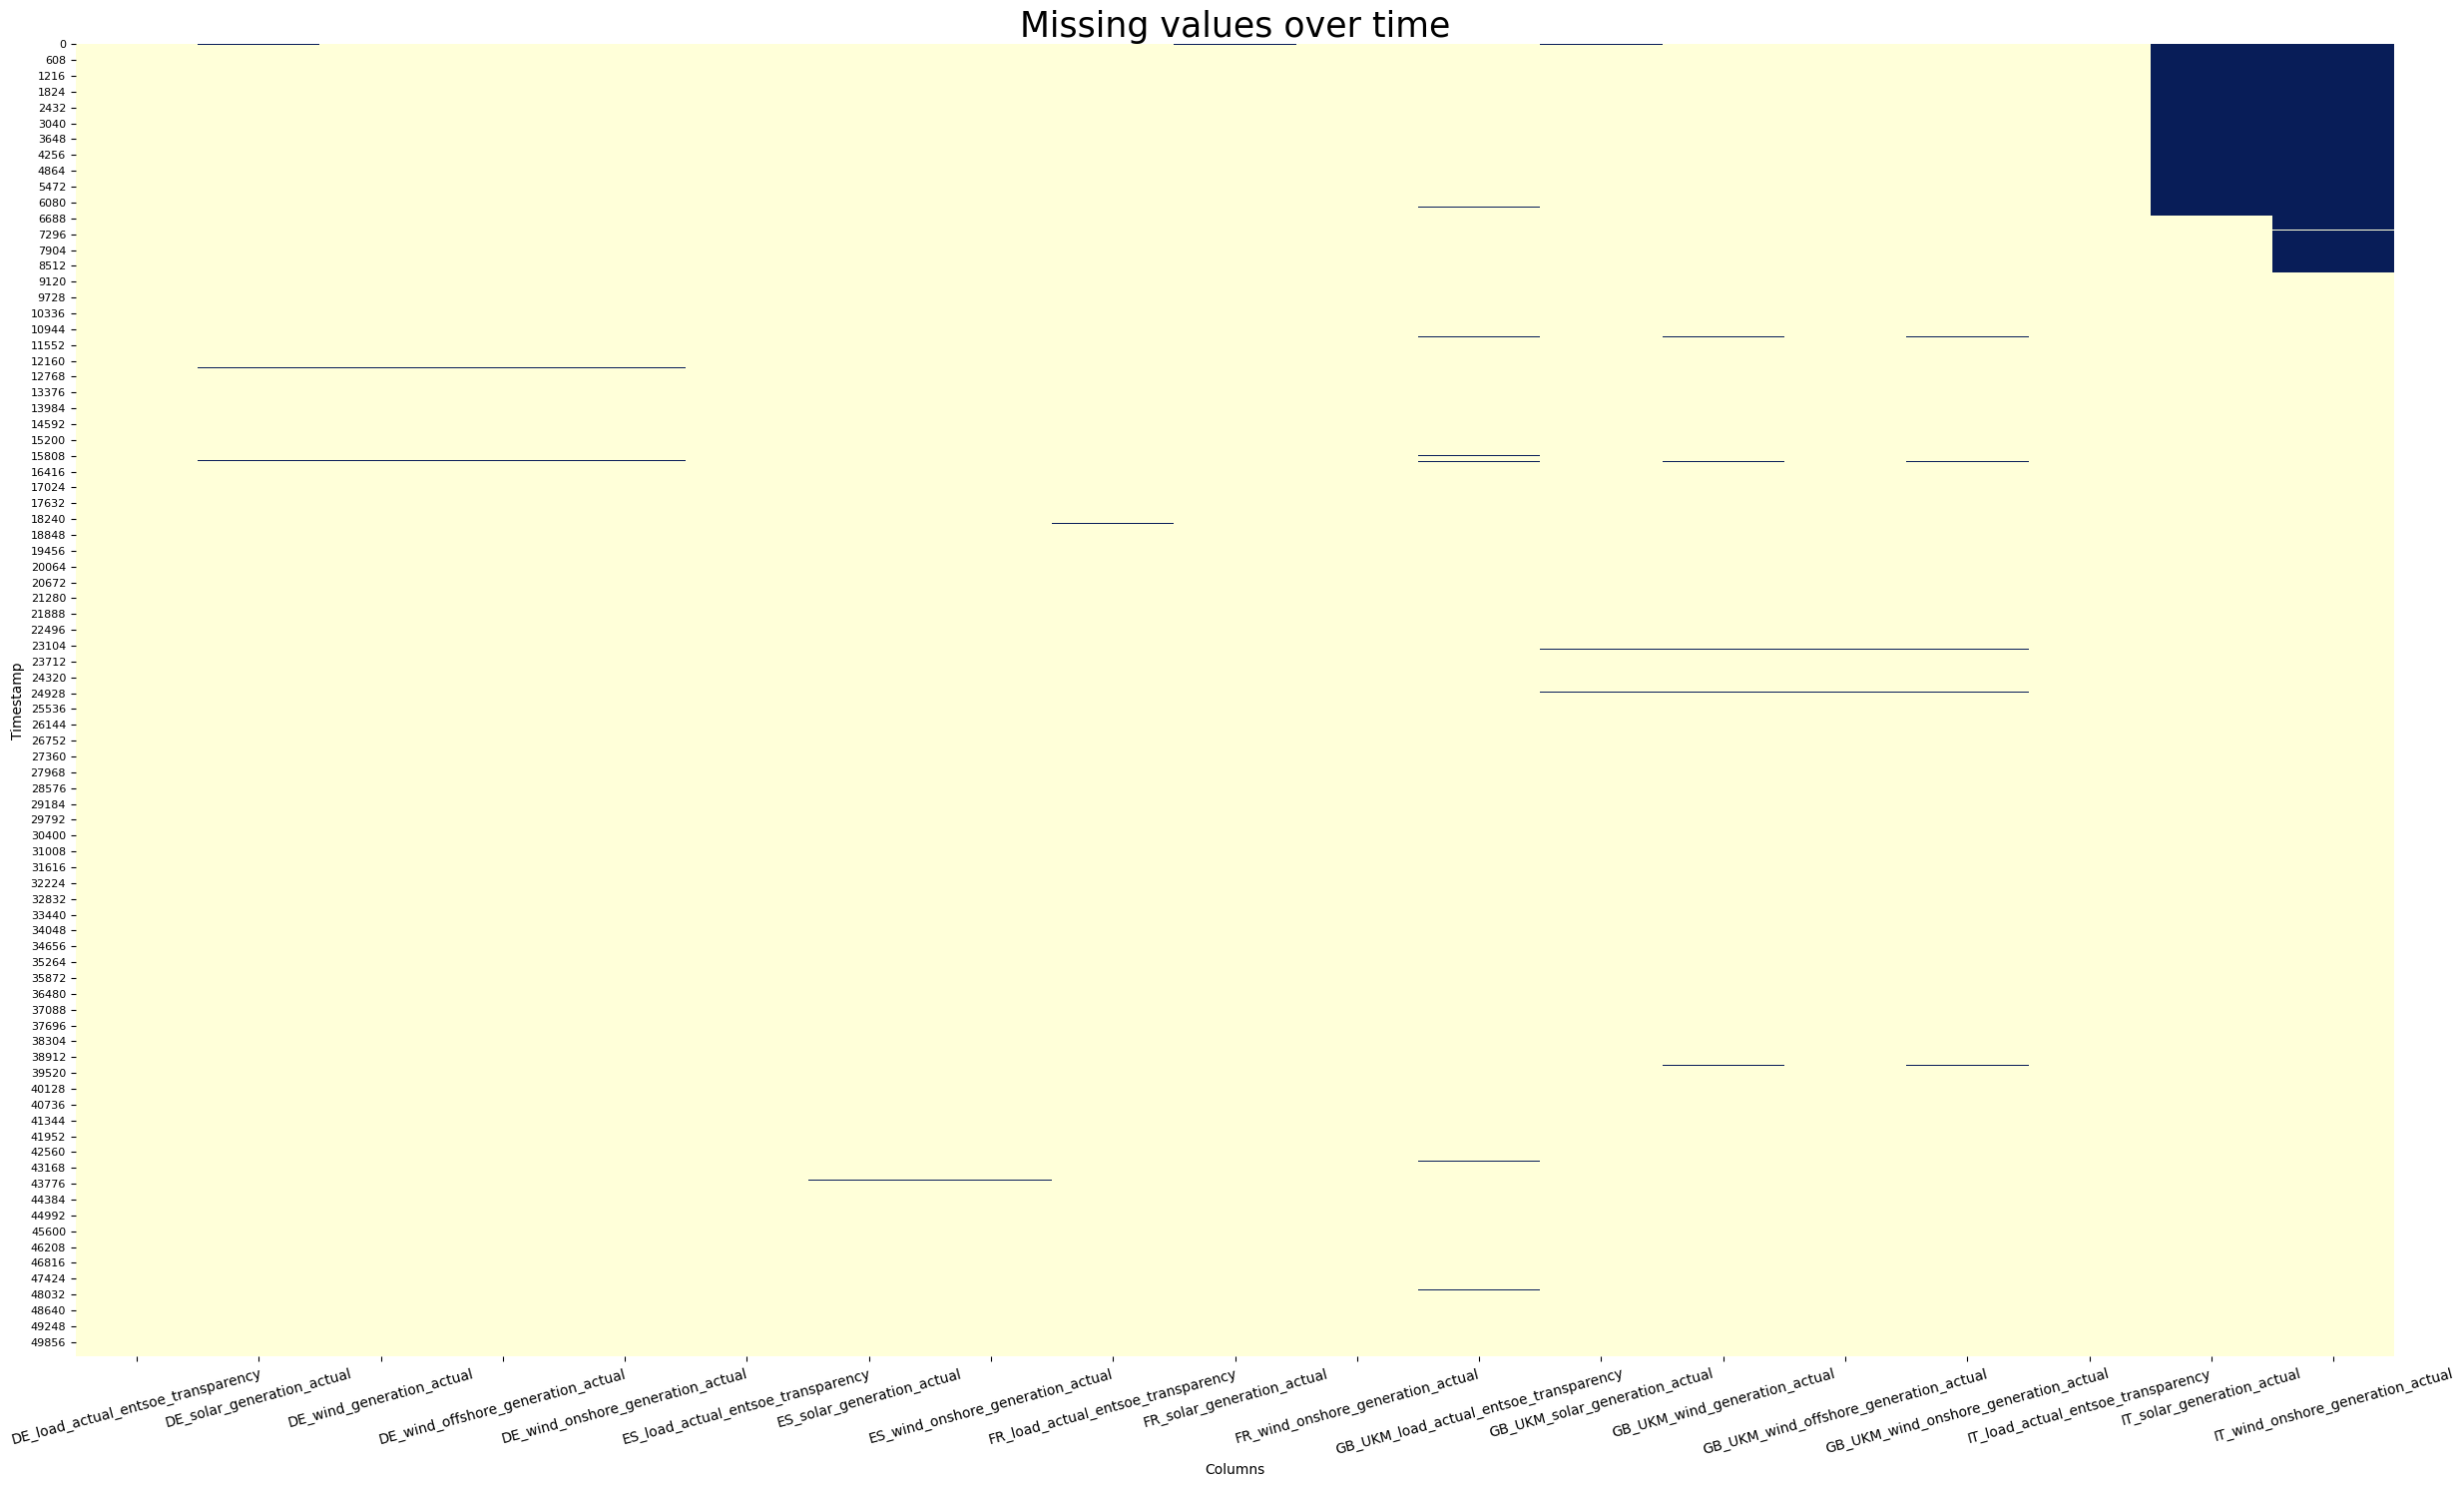

In [30]:
plot_missings(df_top_5.loc[:, df_top_5.columns != 'date'])

In [31]:
# Keep in mind we have to drop last day, because it is not full
df_top_5.tail(10)

,date,DE_load_actual_entsoe_transparency,DE_solar_generation_actual,DE_wind_generation_actual,DE_wind_offshore_generation_actual,DE_wind_onshore_generation_actual,ES_load_actual_entsoe_transparency,ES_solar_generation_actual,ES_wind_onshore_generation_actual,FR_load_actual_entsoe_transparency,FR_solar_generation_actual,FR_wind_onshore_generation_actual,GB_UKM_load_actual_entsoe_transparency,GB_UKM_solar_generation_actual,GB_UKM_wind_generation_actual,GB_UKM_wind_offshore_generation_actual,GB_UKM_wind_onshore_generation_actual,IT_load_actual_entsoe_transparency,IT_solar_generation_actual,IT_wind_onshore_generation_actual
50391,2020-09-30 14:00:00+00:00,61396.0,10270.0,3377.0,2369.0,1008.0,29115.0,5028.0,3814.0,49154.0,3983.0,2778.0,38546.0,646.0,8224.0,4637.0,3587.0,37263.0,4943.0,696.0
50392,2020-09-30 15:00:00+00:00,61436.0,4943.0,3840.0,2696.0,1144.0,29012.0,4160.0,4368.0,48388.0,2546.0,2711.0,41124.0,484.0,7489.0,4594.0,2894.0,36850.0,2345.0,831.0
50393,2020-09-30 16:00:00+00:00,61432.0,807.0,4538.0,2905.0,1633.0,28772.0,2489.0,4760.0,50111.0,1002.0,2731.0,42353.0,296.0,7292.0,4499.0,2793.0,37177.0,NaN,721.0
50394,2020-09-30 17:00:00+00:00,63459.0,1.0,6444.0,3877.0,2568.0,29096.0,630.0,4876.0,53304.0,204.0,2827.0,42344.0,142.0,7347.0,4733.0,2614.0,40102.0,NaN,562.0
50395,2020-09-30 18:00:00+00:00,61177.0,0.0,8526.0,4416.0,4111.0,31492.0,108.0,5395.0,51975.0,140.0,3185.0,41750.0,NaN,7070.0,4531.0,2540.0,38208.0,NaN,518.0
50396,2020-09-30 19:00:00+00:00,57559.0,0.0,10654.0,4754.0,5900.0,30860.0,29.0,6047.0,48210.0,142.0,3632.0,38640.0,NaN,7083.0,4740.0,2343.0,35217.0,NaN,515.0
50397,2020-09-30 20:00:00+00:00,54108.0,0.0,11836.0,5194.0,6642.0,27994.0,21.0,6617.0,48210.0,142.0,3965.0,34913.0,NaN,7431.0,5307.0,2124.0,31537.0,NaN,546.0
50398,2020-09-30 21:00:00+00:00,49845.0,0.0,12168.0,5339.0,6829.0,25706.0,21.0,6636.0,48058.0,143.0,4201.0,30637.0,NaN,7788.0,5674.0,2114.0,28730.0,NaN,519.0
50399,2020-09-30 22:00:00+00:00,46886.0,0.0,12533.0,5399.0,7134.0,24926.0,22.0,6783.0,44869.0,142.0,4428.0,25362.0,NaN,4627.0,2998.0,1629.0,26269.0,NaN,489.0
50400,2020-09-30 23:00:00+00:00,45461.0,0.0,12798.0,5381.0,7417.0,NaN,NaN,NaN,NaN,NaN,NaN,22208.0,NaN,7382.0,5572.0,1810.0,NaN,NaN,NaN


In [32]:
# The start of notna data
min_date = df_top_5.loc[df_top_5['IT_wind_onshore_generation_actual'].notna()]['date'].min()
df_top_5 = df_top_5[df_top_5['date'] >= min_date]
min_date

Timestamp('2015-10-24 23:00:00+0000', tz='UTC')

Italy has missing values at the start of the dataframe. Since we want to have unified periods, we should drop them.

We still have missing values, let's treat them.

In [33]:
# Check for missings again
df_top_5.isna().sum()

date                                         0
DE_load_actual_entsoe_transparency           0
DE_solar_generation_actual                  72
DE_wind_generation_actual                   74
DE_wind_offshore_generation_actual          74
DE_wind_onshore_generation_actual           72
ES_load_actual_entsoe_transparency           4
ES_solar_generation_actual                   9
ES_wind_onshore_generation_actual            9
FR_load_actual_entsoe_transparency          42
FR_solar_generation_actual                   6
FR_wind_onshore_generation_actual            6
GB_UKM_load_actual_entsoe_transparency     163
GB_UKM_solar_generation_actual              38
GB_UKM_wind_generation_actual              120
GB_UKM_wind_offshore_generation_actual      32
GB_UKM_wind_onshore_generation_actual      120
IT_load_actual_entsoe_transparency           1
IT_solar_generation_actual                  17
IT_wind_onshore_generation_actual         1618
dtype: int64

In [34]:
# IT_wind_onshore_generation_actual still has many missings
# Everyday till the end of the 2015

df_top_5.set_index('date', inplace=True)
missing_days = df_top_5['IT_wind_onshore_generation_actual'].resample('D').apply(lambda x: x.isna().all())

# Filter to get only the days with missing data
missing_days[missing_days].index.strftime('%Y-%m-%d').tolist()

['2015-10-26',
 '2015-10-27',
 '2015-10-28',
 '2015-10-29',
 '2015-10-30',
 '2015-10-31',
 '2015-11-01',
 '2015-11-02',
 '2015-11-03',
 '2015-11-04',
 '2015-11-05',
 '2015-11-06',
 '2015-11-07',
 '2015-11-08',
 '2015-11-09',
 '2015-11-10',
 '2015-11-11',
 '2015-11-12',
 '2015-11-13',
 '2015-11-14',
 '2015-11-15',
 '2015-11-16',
 '2015-11-17',
 '2015-11-18',
 '2015-11-19',
 '2015-11-20',
 '2015-11-21',
 '2015-11-22',
 '2015-11-23',
 '2015-11-24',
 '2015-11-25',
 '2015-11-26',
 '2015-11-27',
 '2015-11-28',
 '2015-11-29',
 '2015-11-30',
 '2015-12-01',
 '2015-12-02',
 '2015-12-03',
 '2015-12-04',
 '2015-12-05',
 '2015-12-06',
 '2015-12-07',
 '2015-12-08',
 '2015-12-09',
 '2015-12-10',
 '2015-12-11',
 '2015-12-12',
 '2015-12-13',
 '2015-12-14',
 '2015-12-15',
 '2015-12-16',
 '2015-12-17',
 '2015-12-18',
 '2015-12-19',
 '2015-12-20',
 '2015-12-21',
 '2015-12-22',
 '2015-12-23',
 '2015-12-24',
 '2015-12-25',
 '2015-12-26',
 '2015-12-27',
 '2015-12-28',
 '2015-12-29',
 '2015-12-30']

In [35]:
# Full November, if resample by month
missing_days = df_top_5['IT_wind_onshore_generation_actual'].resample('M').apply(lambda x: x.isna().all())

# Filter to get only the days with missing data
missing_days[missing_days].index.strftime('%Y-%m-%d').tolist()

['2015-11-30']

In [36]:
# Drop until that date
df_top_5 = df_top_5[df_top_5.index.date > date(2015, 12, 30)]

# Check again
df_top_5.isna().sum()

DE_load_actual_entsoe_transparency          0
DE_solar_generation_actual                 72
DE_wind_generation_actual                  74
DE_wind_offshore_generation_actual         74
DE_wind_onshore_generation_actual          72
ES_load_actual_entsoe_transparency          4
ES_solar_generation_actual                  9
ES_wind_onshore_generation_actual           9
FR_load_actual_entsoe_transparency         42
FR_solar_generation_actual                  6
FR_wind_onshore_generation_actual           6
GB_UKM_load_actual_entsoe_transparency    149
GB_UKM_solar_generation_actual             38
GB_UKM_wind_generation_actual             117
GB_UKM_wind_offshore_generation_actual     32
GB_UKM_wind_onshore_generation_actual     117
IT_load_actual_entsoe_transparency          1
IT_solar_generation_actual                 17
IT_wind_onshore_generation_actual          33
dtype: int64

We select the columns with daily seasonality to impute missing values there with the previous day's values at exactly same hour. 
We suppose that such imputation is a better choice here than simple linear extrapolation. For example, for solar generation values at night might be zeroes every day, therefore we should impute such missings with zeroes rather that linearly.

In [37]:
selected_columns = [col for col in df_top_5.columns if 'load' in col or 'solar' in col]

In [38]:
# Impute missing values for Load and Solar with previous day observations at the same time
columns_shift = df_top_5[selected_columns].shift(freq='24H')

# Fill missing values with values from the previous day
df_top_5 = df_top_5.fillna(columns_shift)

# Fill wind columns with linear/time interpolation
# In our case it is linear interpolation (because distance between time points is the same)
df_top_5.interpolate(method='time', axis=0, inplace=True) 

In [39]:
df_top_5.isna().sum()
# 2015-12-31 has 23 hours missing, but we keep it because later we will change time to local time
# In Italy, there will be +1 hour to UTC in winter

DE_load_actual_entsoe_transparency         0
DE_solar_generation_actual                 0
DE_wind_generation_actual                  0
DE_wind_offshore_generation_actual         0
DE_wind_onshore_generation_actual          0
ES_load_actual_entsoe_transparency         0
ES_solar_generation_actual                 0
ES_wind_onshore_generation_actual          0
FR_load_actual_entsoe_transparency         0
FR_solar_generation_actual                 0
FR_wind_onshore_generation_actual          0
GB_UKM_load_actual_entsoe_transparency     0
GB_UKM_solar_generation_actual             0
GB_UKM_wind_generation_actual              0
GB_UKM_wind_offshore_generation_actual     0
GB_UKM_wind_onshore_generation_actual      0
IT_load_actual_entsoe_transparency         0
IT_solar_generation_actual                 0
IT_wind_onshore_generation_actual         23
dtype: int64

# 6. Outliers

In general we keep all values, because they seem to be true values though they are detected as outliers.
But we need to choose then appropriate loss function and interpret errors carefully.

In [40]:
# 1.5 IQR - regular
print(f"{'Column name':<40} {'Number of outliers':>15} {'Percentage in dataset':>20}")
for col_name in df_top_5.select_dtypes(include='float').columns:
    count_outliers(df_top_5[col_name])

Column name                              Number of outliers Percentage in dataset
DE_load_actual_entsoe_transparency                     0                  0.0%
DE_solar_generation_actual                          2935                  7.0%
DE_wind_generation_actual                           1225                  2.9%
DE_wind_offshore_generation_actual                     0                  0.0%
DE_wind_onshore_generation_actual                   1831                  4.4%
ES_load_actual_entsoe_transparency                     0                  0.0%
ES_solar_generation_actual                           803                  1.9%
ES_wind_onshore_generation_actual                    497                  1.2%
FR_load_actual_entsoe_transparency                   106                  0.3%
FR_solar_generation_actual                          1142                  2.7%
FR_wind_onshore_generation_actual                   2203                  5.3%
GB_UKM_load_actual_entsoe_transparency           

In [41]:
for col_name in df_top_5.select_dtypes(include='float').columns:
    count_outliers(df_top_5[col_name], verbose=True)

Column name: 'DE_solar_generation_actual'
lower bound:      -11353.875,   upper bound:       18923.125
min value:               0.0,    max:                 32947.0
--------------------------------------------------------------------------------
Column name: 'DE_wind_generation_actual'
lower bound:       -13201.75,   upper bound:        34984.25
min value:             135.0,    max:                 46064.0
--------------------------------------------------------------------------------
Column name: 'DE_wind_onshore_generation_actual'
lower bound:        -11252.0,   upper bound:         28692.0
min value:             119.0,    max:                 40752.0
--------------------------------------------------------------------------------
Column name: 'ES_solar_generation_actual'
lower bound:       -4235.375,   upper bound:        7237.625
min value:               0.0,    max:                  9338.0
--------------------------------------------------------------------------------
Column nam

In [42]:
# 3 IQR - extreme
print(f"{'Column name':<40} {'Number of outliers':>15} {'Percentage in dataset':>20}")
for col_name in df_top_5.select_dtypes(include='float').columns:
    count_outliers(df_top_5[col_name], extreme=True)

Column name                              Number of outliers Percentage in dataset
DE_load_actual_entsoe_transparency                     0                  0.0%
DE_solar_generation_actual                            43                  0.1%
DE_wind_generation_actual                              0                  0.0%
DE_wind_offshore_generation_actual                     0                  0.0%
DE_wind_onshore_generation_actual                      0                  0.0%
ES_load_actual_entsoe_transparency                     0                  0.0%
ES_solar_generation_actual                             0                  0.0%
ES_wind_onshore_generation_actual                      0                  0.0%
FR_load_actual_entsoe_transparency                     1                  0.0%
FR_solar_generation_actual                             0                  0.0%
FR_wind_onshore_generation_actual                     61                  0.1%
GB_UKM_load_actual_entsoe_transparency           

In [43]:
# 3 IQR - extreme
print(f"{'Column name':<40} {'Number of outliers':>15} {'Percentage in dataset':>20}")
for col_name in df_top_5.select_dtypes(include='float').columns:
    count_outliers(df_top_5[col_name], extreme=True, verbose=True)

Column name                              Number of outliers Percentage in dataset
Column name: 'DE_solar_generation_actual'
lower bound:       -22707.75,   upper bound:         30277.0
min value:               0.0,    max:                 32947.0
--------------------------------------------------------------------------------
Column name: 'FR_load_actual_entsoe_transparency'
lower bound:         -7140.5,   upper bound:        112570.0
min value:           29398.0,    max:                158000.0
--------------------------------------------------------------------------------
Column name: 'FR_wind_onshore_generation_actual'
lower bound:         -6700.0,   upper bound:         12144.0
min value:             330.0,    max:                 12976.0
--------------------------------------------------------------------------------
Column name: 'GB_UKM_solar_generation_actual'
lower bound:         -6120.0,   upper bound:          8160.0
min value:               0.0,    max:                  954

In [44]:
# It is only one such outlier and will be in the test set
df_top_5[df_top_5['FR_load_actual_entsoe_transparency'] > 90000]['FR_load_actual_entsoe_transparency']

date
2017-01-18 07:00:00+00:00     92199.0
2017-01-18 08:00:00+00:00     92419.0
2017-01-18 09:00:00+00:00     91669.0
2017-01-18 10:00:00+00:00     90613.0
2017-01-18 17:00:00+00:00     91463.0
2017-01-18 18:00:00+00:00     91891.0
2017-01-19 06:00:00+00:00     91654.0
2017-01-19 07:00:00+00:00     93256.0
2017-01-19 08:00:00+00:00     93123.0
2017-01-19 09:00:00+00:00     91987.0
2017-01-19 10:00:00+00:00     90849.0
2017-01-19 17:00:00+00:00     91437.0
2017-01-19 18:00:00+00:00     91967.0
2017-01-20 06:00:00+00:00     91644.0
2017-01-20 07:00:00+00:00     93696.0
2017-01-20 08:00:00+00:00     93473.0
2017-01-20 09:00:00+00:00     92073.0
2017-01-20 10:00:00+00:00     90676.0
2017-01-24 07:00:00+00:00     90816.0
2017-01-24 08:00:00+00:00     90860.0
2017-01-25 08:00:00+00:00     90520.0
2017-01-25 09:00:00+00:00     90809.0
2017-01-25 10:00:00+00:00     90478.0
2017-01-25 11:00:00+00:00     90003.0
2017-01-25 17:00:00+00:00     91006.0
2017-01-25 18:00:00+00:00     91403.0
2017-01

In [45]:
# It is only one such outlier and will be in the test set
df_top_5[df_top_5['FR_load_actual_entsoe_transparency'] > 100000]['FR_load_actual_entsoe_transparency']

date
2020-07-07 17:00:00+00:00    158000.0
Name: FR_load_actual_entsoe_transparency, dtype: float64

In [46]:
# Must likely a data collection error, because 
# in the previous day and next day to this time consumption was around the sorrounding values.

target_date = pd.Timestamp('2020-07-07 17:00:00+00:00')
time_delta = pd.Timedelta(hours=25)  
df_top_5[(df_top_5.index >= target_date - time_delta) & (df_top_5.index <= target_date + time_delta)]['FR_load_actual_entsoe_transparency']

date
2020-07-06 16:00:00+00:00     47379.0
2020-07-06 17:00:00+00:00     47983.0
2020-07-06 18:00:00+00:00     45767.0
2020-07-06 19:00:00+00:00     43882.0
2020-07-06 20:00:00+00:00     46020.0
2020-07-06 21:00:00+00:00     46690.0
2020-07-06 22:00:00+00:00     42824.0
2020-07-06 23:00:00+00:00     40020.0
2020-07-07 00:00:00+00:00     38440.0
2020-07-07 01:00:00+00:00     36403.0
2020-07-07 02:00:00+00:00     35912.0
2020-07-07 03:00:00+00:00     37375.0
2020-07-07 04:00:00+00:00     39979.0
2020-07-07 05:00:00+00:00     43814.0
2020-07-07 06:00:00+00:00     47227.0
2020-07-07 07:00:00+00:00     49414.0
2020-07-07 08:00:00+00:00     50484.0
2020-07-07 09:00:00+00:00     51590.0
2020-07-07 10:00:00+00:00     52780.0
2020-07-07 11:00:00+00:00     51871.0
2020-07-07 12:00:00+00:00     51250.0
2020-07-07 13:00:00+00:00     49880.0
2020-07-07 14:00:00+00:00     48735.0
2020-07-07 15:00:00+00:00     47869.0
2020-07-07 16:00:00+00:00     49768.0
2020-07-07 17:00:00+00:00    158000.0
2020-07

In [47]:
# We reset it with value 50000 so this error will not impact our evaluation too much.
# The other values seem to be plausible values.
df_top_5.at['2020-07-07 17:00:00+00:00', 'FR_load_actual_entsoe_transparency'] = 50000

In [48]:
# Create a folder named "datasets" if it doesn't exist
folder_name = "datasets"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# Save to csv
df_top_5.to_csv('./datasets/top_5_countries.csv')